In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('TG.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Confirmed'

In [5]:
df.Date.describe()

count           115
unique          115
top       05-Apr-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,1,0,0
1,15-Mar-20,2,1,0
2,16-Mar-20,1,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,8,0,0
...,...,...,...,...
110,02-Jul-20,1213,987,8
111,03-Jul-20,1892,1126,8
112,04-Jul-20,1850,1342,5
113,05-Jul-20,1590,1166,7


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0
...,...,...,...,...
110,2020-07-02,1213,987,8
111,2020-07-03,1892,1126,8
112,2020-07-04,1850,1342,5
113,2020-07-05,1590,1166,7


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


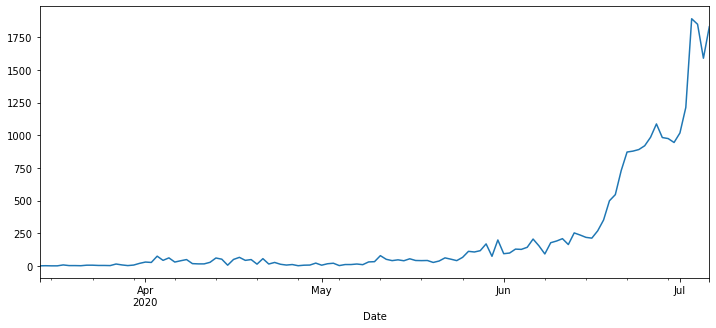

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        6.948175
p-value                   1.000000
# lags used              10.000000
# observations          104.000000
critical value (1%)      -3.494850
critical value (5%)      -2.889758
critical value (10%)     -2.581822
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


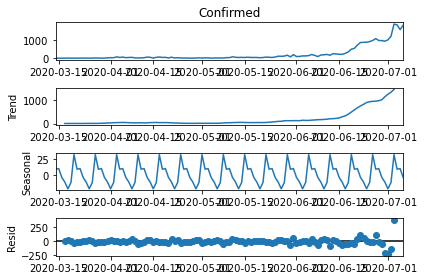

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.126422e+00
p-value                 8.607278e-08
# lags used             1.100000e+01
# observations          1.010000e+02
critical value (1%)    -3.496818e+00
critical value (5%)    -2.890611e+00
critical value (10%)   -2.582277e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=6)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1395.824, BIC=1401.278, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1383.014, BIC=1391.196, Time=0.037 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1327.614, BIC=1335.796, Time=0.068 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1393.863, BIC=1396.590, Time=0.009 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1353.522, BIC=1364.432, Time=0.075 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1341.383, BIC=1355.020, Time=0.111 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1339.807, BIC=1356.171, Time=0.240 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercept=True]; AIC=1325.251, BIC=1344.342, Time=0.422 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1323.432, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -655.719
Date:                Wed, 15 Jul 2020   AIC                           1321.437
Time:                        22:48:08   BIC                           1335.074
Sample:                             0   HQIC                          1326.971
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1309      1.031      1.097      0.273      -0.890       3.152
ar.L1         -0.0048      0.075     -0.064      0.949      -0.152       0.143
ar.L2         -0.3532      0.081     -4.366      0.000      -0.512      -0.195
ma.L1         -0.9165      0.066    -13.951      0.000      -1.045      -0.788
sigma2      6278.2404    366.275     17.141      0.000    5560.356    6996.125
===================================================================================
Ljung-Box (Q):                       22.93   Jarque-Bera (JB):              6326.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              26.59   Skew:                             4.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(2,2,1))
model = SARIMAX(train[para],order=(2,2,1),seasonal_order=(2,2,1,6))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Confirmed   No. Observations:                  104
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 6)   Log Likelihood                -488.233
Date:                           Wed, 15 Jul 2020   AIC                            990.466
Time:                                   22:48:09   BIC                           1007.965
Sample:                               03-14-2020   HQIC                           997.523
                                    - 06-25-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0900      0.100     -0.898      0.369      -0.287       0.106
ar.L2          0.1782      0.104      1.705      0.088      -0.027       0.383
ma.L1         -0.9997      8.727     -0.115      0.909     -18.104      16.105
ar.S.L6       -0.6722      0.104     -6.442      0.000      -0.877      -0.468
ar.S.L12      -0.3732      0.165     -2.257      0.024      -0.697      -0.049
ma.S.L6       -0.9996     72.576     -0.014      0.989    -143.245     141.246
sigma2      2013.2583   1.51e+05      0.013      0.989   -2.93e+05    2.97e+05
===================================================================================
Ljung-Box (Q):                       22.73   Jarque-Bera (JB):                 8.05
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               7.23   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2,2,1,6) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

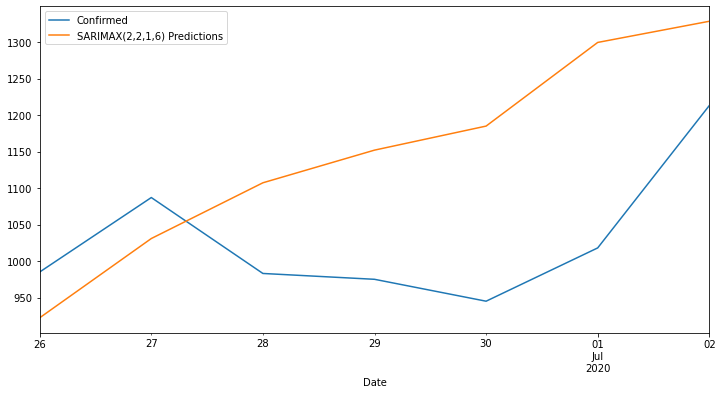

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

150.98334815476974

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

14.981947026912826 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,1,0,0,NaN,NaN
2020-03-15,2,1,0,NaN,NaN
2020-03-16,1,0,0,-2.0,NaN
2020-03-17,1,0,0,1.0,NaN
2020-03-18,8,0,0,7.0,NaN
...,...,...,...,...,...
2020-07-02,1213,987,8,122.0,1328.48447
2020-07-03,1892,1126,8,484.0,NaN
2020-07-04,1850,1342,5,-721.0,NaN


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Confirmed': Date
 2020-06-26     985
 2020-06-27    1087
 2020-06-28     983
 2020-06-29     975
 2020-06-30     945
 2020-07-01    1018
 2020-07-02    1213
 Freq: D, Name: Confirmed, dtype: int64,
 'Predicted_Confirmed': 2020-06-26     922.294203
 2020-06-27    1030.855362
 2020-06-28    1107.220129
 2020-06-29    1151.949389
 2020-06-30    1184.894240
 2020-07-01    1299.484773
 2020-07-02    1328.484470
 Freq: D, Name: SARIMAX(2,2,1,6) Predictions, dtype: float64}

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Confirmed,Predicted_Confirmed
Date,,
2020-06-26,985,922.294203
2020-06-27,1087,1030.855362
2020-06-28,983,1107.220129
2020-06-29,975,1151.949389
2020-06-30,945,1184.894240
2020-07-01,1018,1299.484773
2020-07-02,1213,1328.484470


In [33]:
predicted_df.to_csv('Predicted_TG.csv')
# predicted_csv = pd.read_csv('Predicted_TG.csv')

# predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
# predicted_csv.set_index('Date', inplace=True)
# predicted_csv.index.freq = 'D'
# # print(predicted_csv)
# # predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
# predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(predicted_csv)
# predicted_csv.to_csv('Predicted_TG.csv')

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,1,0,0,NaN
2020-03-15,2,1,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,8,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Confirmed,forecast
2020-03-14,1,NaN
2020-03-15,2,NaN
2020-03-16,1,NaN
2020-03-17,1,NaN
2020-03-18,8,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

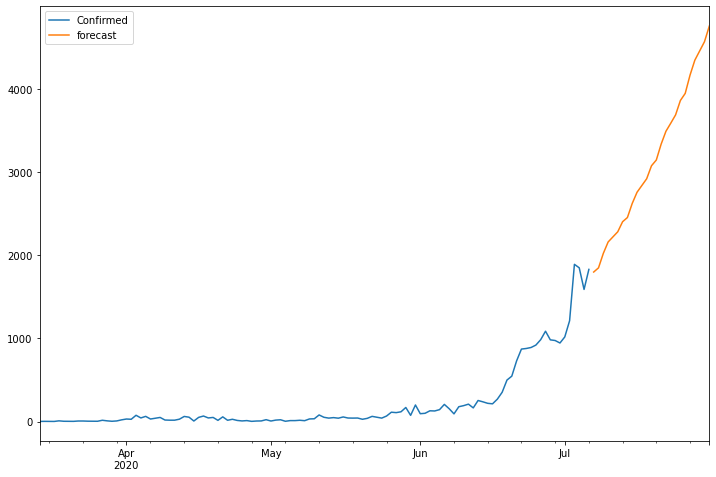

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Confirmed': 2020-07-07    1799.377006
 2020-07-08    1849.404154
 2020-07-09    2023.755527
 2020-07-10    2161.276984
 2020-07-11    2222.075770
 2020-07-12    2283.987344
 2020-07-13    2404.790353
 2020-07-14    2455.207111
 2020-07-15    2624.933851
 2020-07-16    2759.696072
 2020-07-17    2841.586199
 2020-07-18    2921.987450
 2020-07-19    3078.477558
 2020-07-20    3147.471888
 2020-07-21    3338.151589
 2020-07-22    3493.799349
 2020-07-23    3590.768250
 2020-07-24    3690.711996
 2020-07-25    3864.205588
 2020-07-26    3949.447852
 2020-07-27    4169.348127
 2020-07-28    4349.464025
 2020-07-29    4460.010795
 2020-07-30    4571.682603
 2020-07-31    4759.624945
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Confirmed
2020-07-07,1799.377006
2020-07-08,1849.404154
2020-07-09,2023.755527
2020-07-10,2161.276984
2020-07-11,2222.075770
2020-07-12,2283.987344
2020-07-13,2404.790353
2020-07-14,2455.207111
2020-07-15,2624.933851
2020-07-16,2759.696072


In [44]:
future_predicted_df.index.names = ['Date']
future_predicted_df.index.freq = 'D'
future_predicted_df.to_csv('Future_Predicted_TG.csv')

# future_predicted_csv = pd.read_csv('Future_Predicted_TG.csv')

# future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
# future_predicted_csv.set_index('Date', inplace=True)
# future_predicted_csv.index.freq = 'D'
# # print(future_predicted_csv)
# # future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
# future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(future_predicted_csv)
# future_predicted_csv.to_csv('Future_Predicted_TG.csv')